# How to use the VAR model for macro fundamentals forecasts

The vector autoregressive VAR(p) model extends the AR(p) model to k series by creating a system of k equations where each contains p lagged values of all k series. The coefficients on the own lags provide information about the dynamics of the series itself, whereas the cross-variable coefficients offer some insight into the interactions across the series.

## Imports and Settings

In [11]:
import warnings

warnings.filterwarnings("ignore")

In [12]:
%matplotlib inline

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns

from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import minmax_scale
from scipy.stats import probplot, moment
from sklearn.metrics import mean_absolute_error

In [13]:
sns.set(style="whitegrid", context="notebook", color_codes=True)

## Helper Functions

### Correlogram Plot

In [14]:
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x) / 5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title="Time Series")
    x.rolling(21).mean().plot(ax=axes[0][0], c="k", lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f"Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}"
    axes[0][0].text(x=0.02, y=0.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f"Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}"
    axes[0][1].text(x=0.02, y=0.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel("Lag")
    axes[1][1].set_xlabel("Lag")
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)

### Unit Root Test

In [15]:
def test_unit_root(df):
    return df.apply(lambda x: f"{pd.Series(adfuller(x)).iloc[1]:.2%}").to_frame(
        "p-value"
    )

## Load Data

We will extend the univariate example of a single time series of monthly data on industrial production and add a monthly time series on consumer sentiment, both provided by the Federal Reserve's data service. We will use the familiar pandas-datareader library to retrieve data from 1970 through 2017:

In [16]:
# df_sofr
df_sofr = pd.read_excel("../data/sofrdaily.xlsx")
df_sofr = df_sofr[["Effective Date", "Rate (%)"]]
df_sofr["Effective Date"] = pd.to_datetime(df_sofr["Effective Date"])
df_sofr.columns = ["date", "rate_pct"]
df_sofr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1410 entries, 0 to 1409
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1410 non-null   datetime64[ns]
 1   rate_pct  1410 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.2 KB


In [17]:
end_date = df_sofr.iloc[0]["date"]
start_date = df_sofr.iloc[-1]["date"]
end_date

Timestamp('2023-11-20 00:00:00')

In [18]:
# df_effr
df_effr = pd.read_excel("../data/effrdaily.xlsx")
df_effr = df_effr[["Effective Date", "Rate (%)"]]
df_effr["Effective Date"] = pd.to_datetime(df_effr["Effective Date"])
df_effr.columns = ["date", "rate_pct"]
# should i shift 1 day?
df_effr["date"] = df_effr["date"] - pd.Timedelta("1 day")
df_effr = df_effr[(df_effr["date"] <= end_date) & (df_effr["date"] >= start_date)]
df_effr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1418 entries, 0 to 1417
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1418 non-null   datetime64[ns]
 1   rate_pct  1418 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 33.2 KB


In [19]:
# sofr avg
# df_avg = pd.read_excel("sofravg.xlsx")
# df_avg.info()
# df_avg = df_avg[
# [
#    "30-Day Average SOFR",
#    "90-Day Average SOFR",
#    "180-Day Average SOFR",
#    "SOFR Index",
# ]
# ]
# df_avg["Effective Date"] = pd.to_datetime(df_avg["Effective Date"])
# df_avg.columns = ["date", "30d", "90d", "180d", "idx"]
# df_avg.tail()

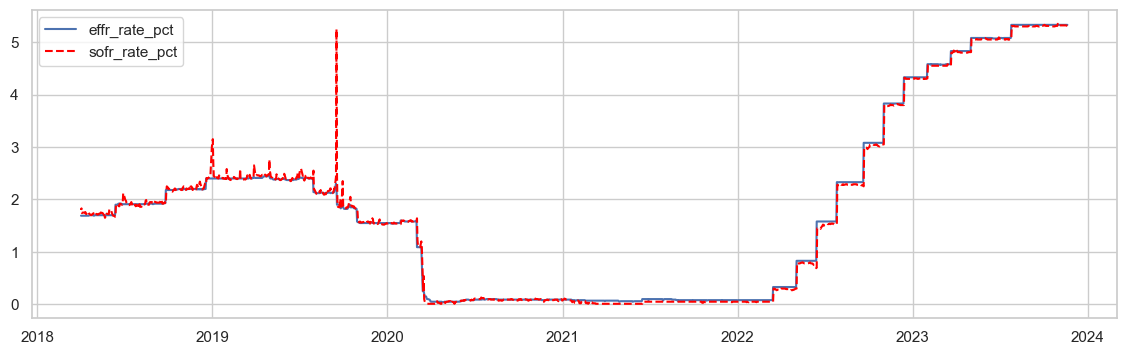

In [20]:
plt.figure(figsize=(14, 4))
plt.plot(df_effr["date"], df_effr["rate_pct"], label="effr_rate_pct")
plt.plot(
    df_sofr["date"],
    df_sofr["rate_pct"],
    label="sofr_rate_pct",
    color="red",
    linestyle="dashed",
)
plt.legend()

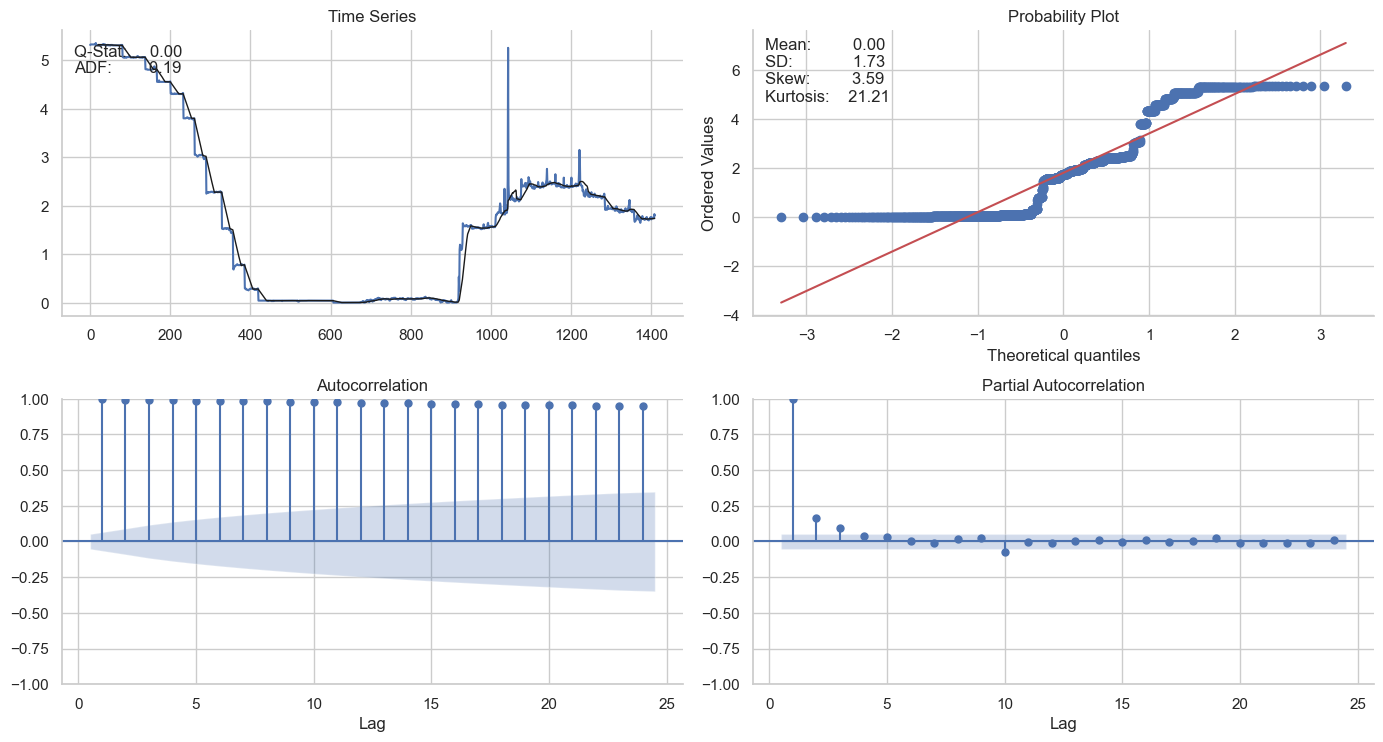

In [21]:
plot_correlogram(df_sofr.rate_pct, lags=24)

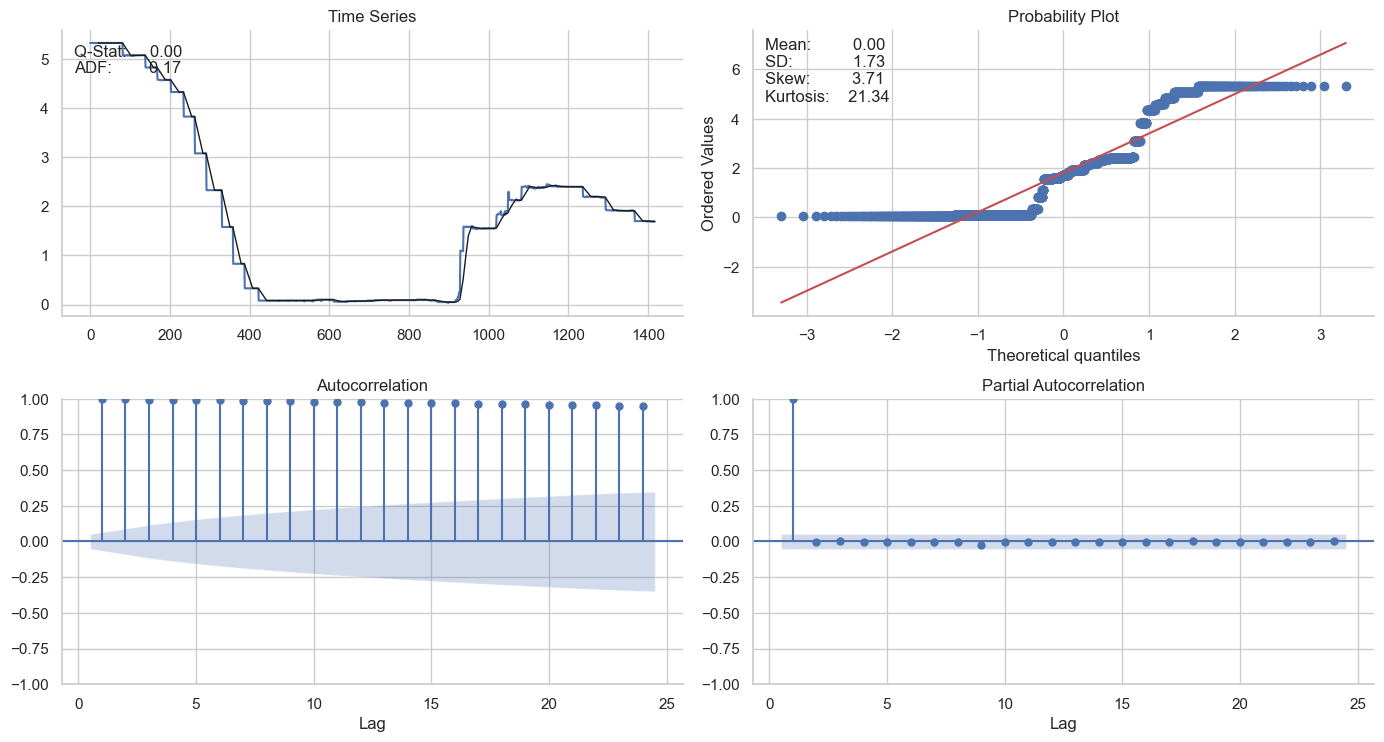

In [22]:
plot_correlogram(df_effr.rate_pct, lags=24)

## Stationarity Transform

Log-transforming the industrial production series and seasonal differencing using lag 12 of both series yields stationary results:

In [23]:
df_transformed = pd.DataFrame(
    {
        "sofr_rate": np.log(df_sofr.rate_pct).diff(12),
        "effr_rate": df_effr.rate_pct.diff(12),
    }
).dropna()

## Inspect Correlograms

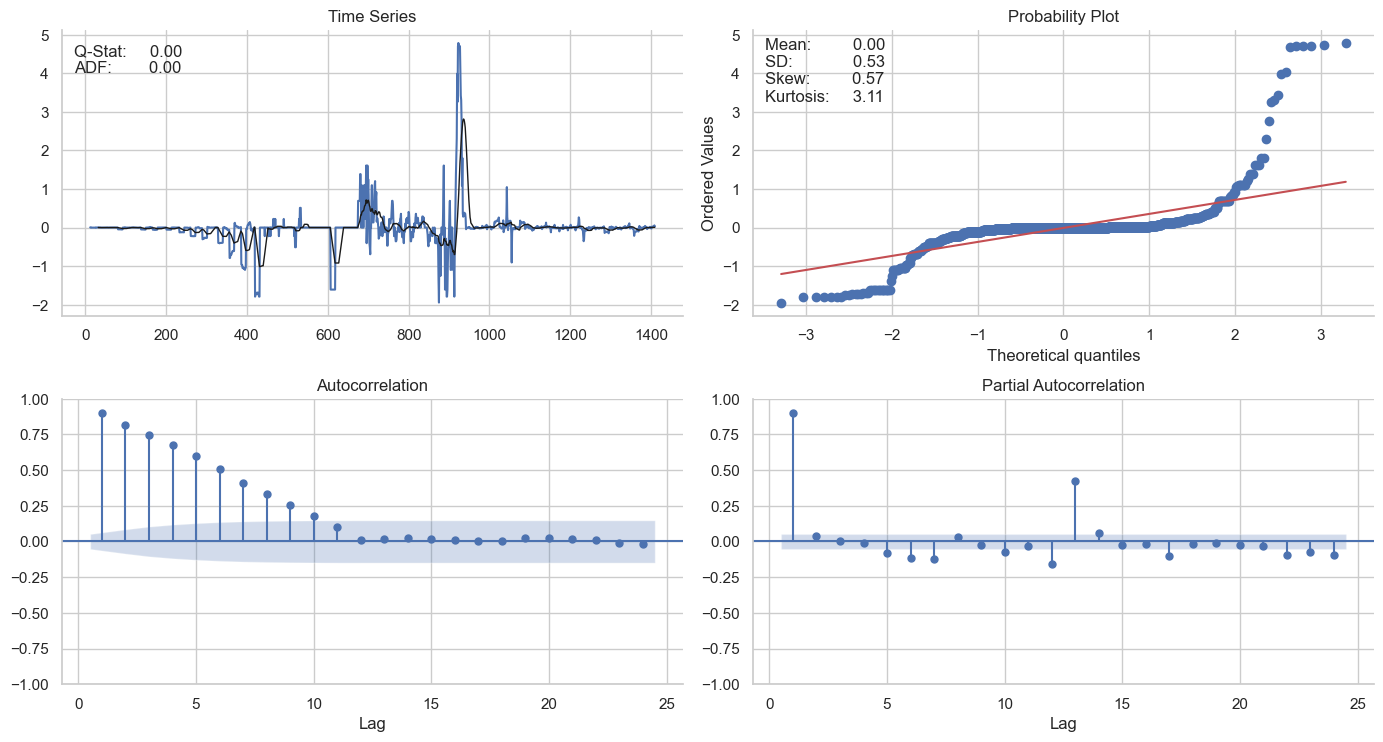

In [24]:
plot_correlogram(df_transformed.sofr_rate, lags=24)

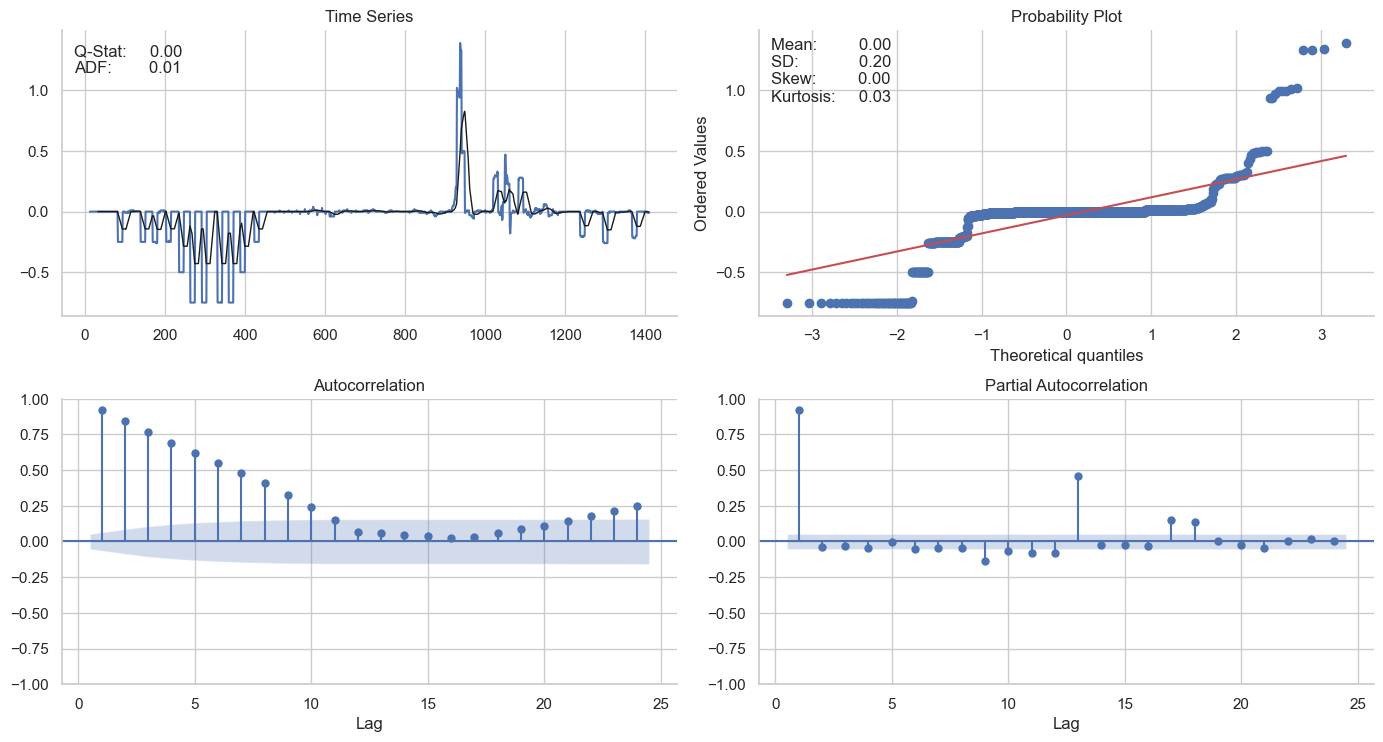

In [25]:
plot_correlogram(df_transformed.effr_rate, lags=24)

In [26]:
test_unit_root(df_transformed)

,p-value
sofr_rate,0.00%
effr_rate,1.27%


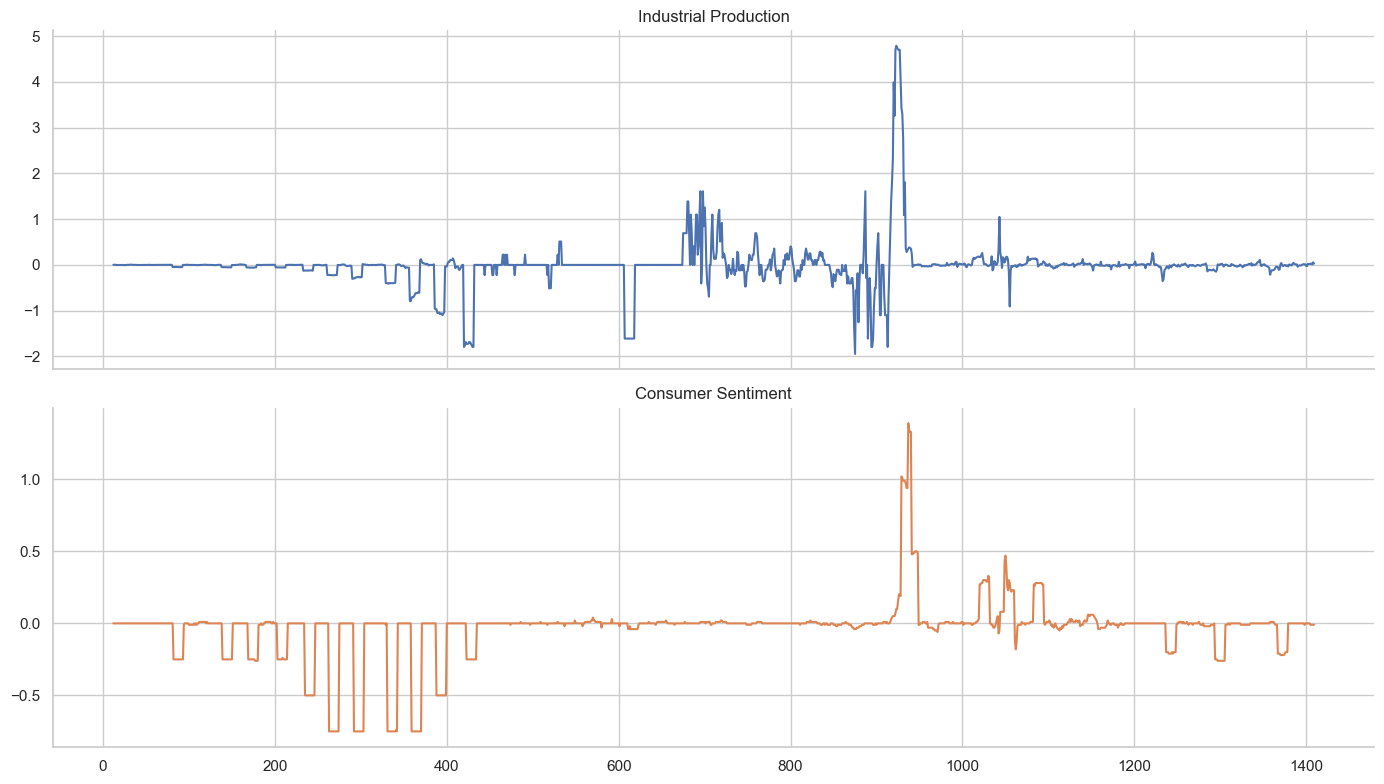

In [27]:
df_transformed.plot(
    subplots=True,
    figsize=(14, 8),
    title=["Industrial Production", "Consumer Sentiment"],
    legend=False,
    rot=0,
)
sns.despine()
plt.tight_layout()

## VAR Model

To limit the size of the output, we will just estimate a VAR(1) model using the statsmodels VARMAX implementation (which allows for optional exogenous variables) with a constant trend through 2017. The output contains the coefficients for both time series equations.

In [28]:
df_transformed = df_transformed.apply(minmax_scale)

In [29]:
model = VARMAX(df_transformed.loc[:"2017"], order=(1, 1), trend="c").fit(maxiter=1000)

In [30]:
print(model.summary())

                               Statespace Model Results                               
Dep. Variable:     ['sofr_rate', 'effr_rate']   No. Observations:                  190
Model:                             VARMA(1,1)   Log Likelihood                1537.126
                                  + intercept   AIC                          -3048.252
Date:                        Thu, 23 Nov 2023   BIC                          -3006.041
Time:                                01:40:08   HQIC                         -3031.153
Sample:                                     0                                         
                                        - 190                                         
Covariance Type:                          opg                                         
Ljung-Box (L1) (Q):             0.00, 0.07   Jarque-Bera (JB):     2986.46, 3565.57
Prob(Q):                        0.99, 0.79   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):       31.80, 23.13   Skew

### Plot Diagnostics

`statsmodels` provides diagnostic plots to check whether the residuals meet the white noise assumptions, which are not exactly met in this simple case:

#### Industrial Production

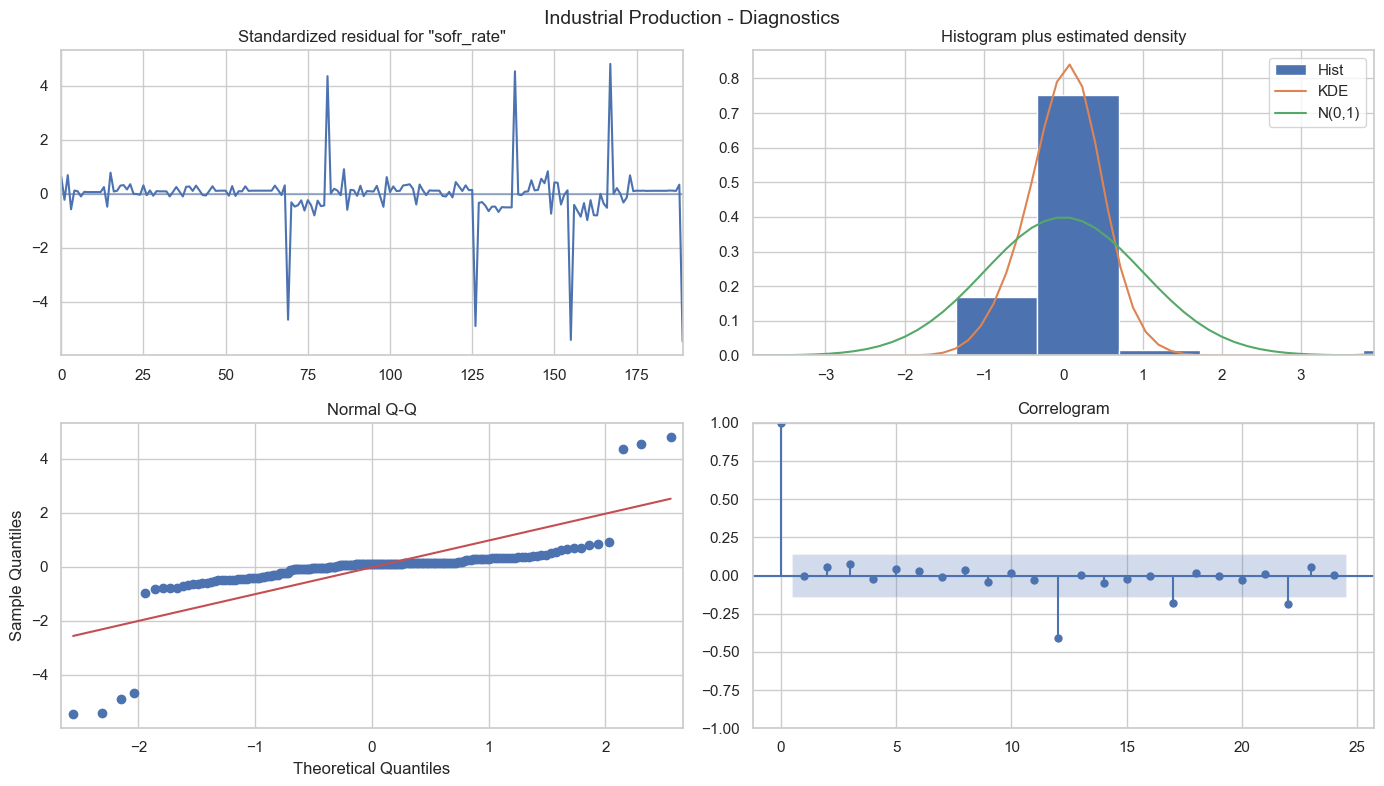

In [31]:
model.plot_diagnostics(variable=0, figsize=(14, 8), lags=24)
plt.gcf().suptitle("Industrial Production - Diagnostics", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.93)

#### Sentiment

Text(0.5, 1.0, 'Sentiment - Diagnostics')

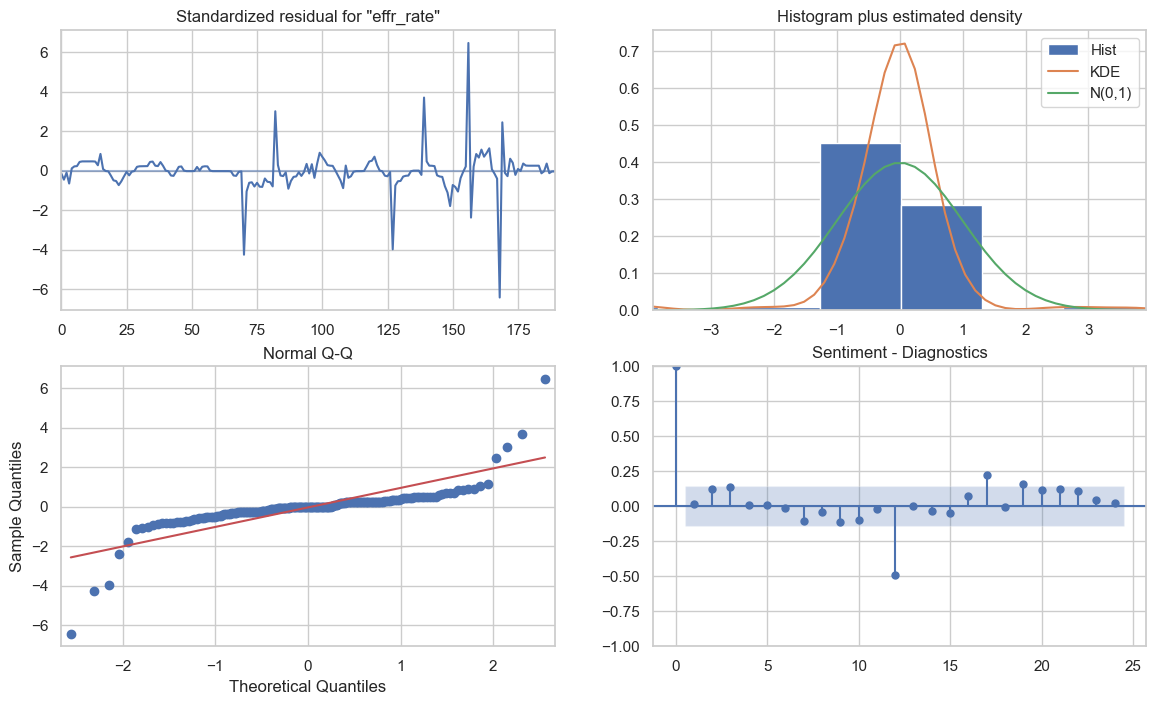

In [32]:
model.plot_diagnostics(variable=1, figsize=(14, 8), lags=24)
plt.title("Sentiment - Diagnostics")

### Impulse-Response Function

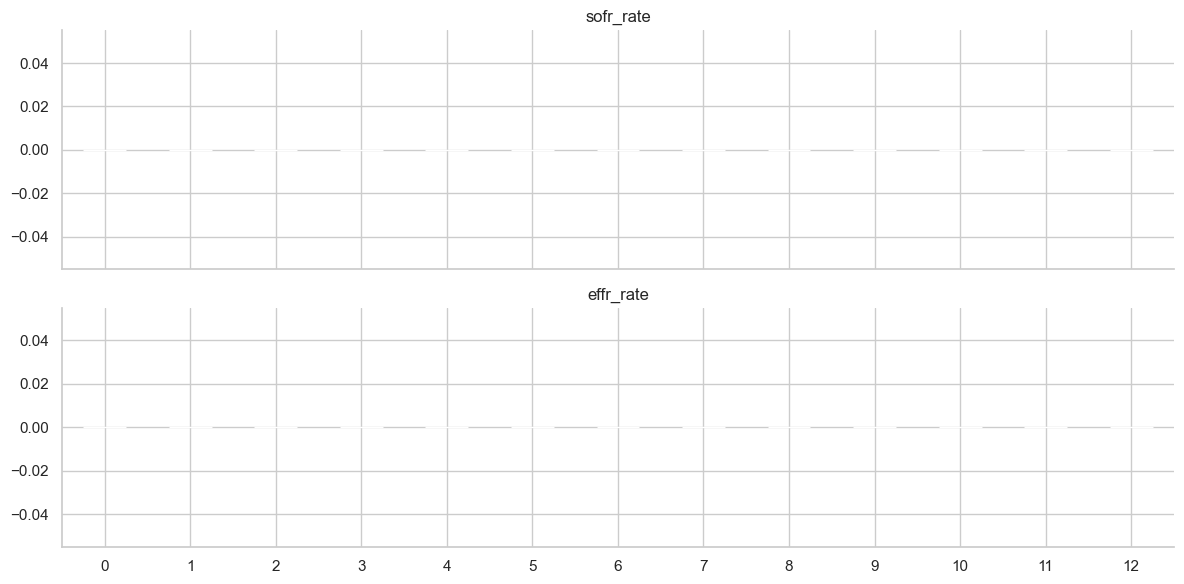

In [33]:
median_change = df_transformed.diff().quantile(0.5).tolist()
model.impulse_responses(steps=12, impulse=median_change).plot.bar(
    subplots=True, figsize=(12, 6), rot=0, legend=False
)
sns.despine()
plt.tight_layout()

### Generate Predictions

Out-of-sample predictions can be generated as follows:

In [34]:
n = len(df_transformed)
start = n - 24

preds = model.predict(start=start + 1, end=n)

In [35]:
df_transformed

,sofr_rate,effr_rate
12,0.289552,0.350467
13,0.288994,0.350467
14,0.289829,0.350467
15,0.288714,0.350467
16,0.288714,0.350467
...,...,...
1405,0.292428,0.345794
1406,0.293299,0.345794
1407,0.290711,0.345794
1408,0.297339,0.345794


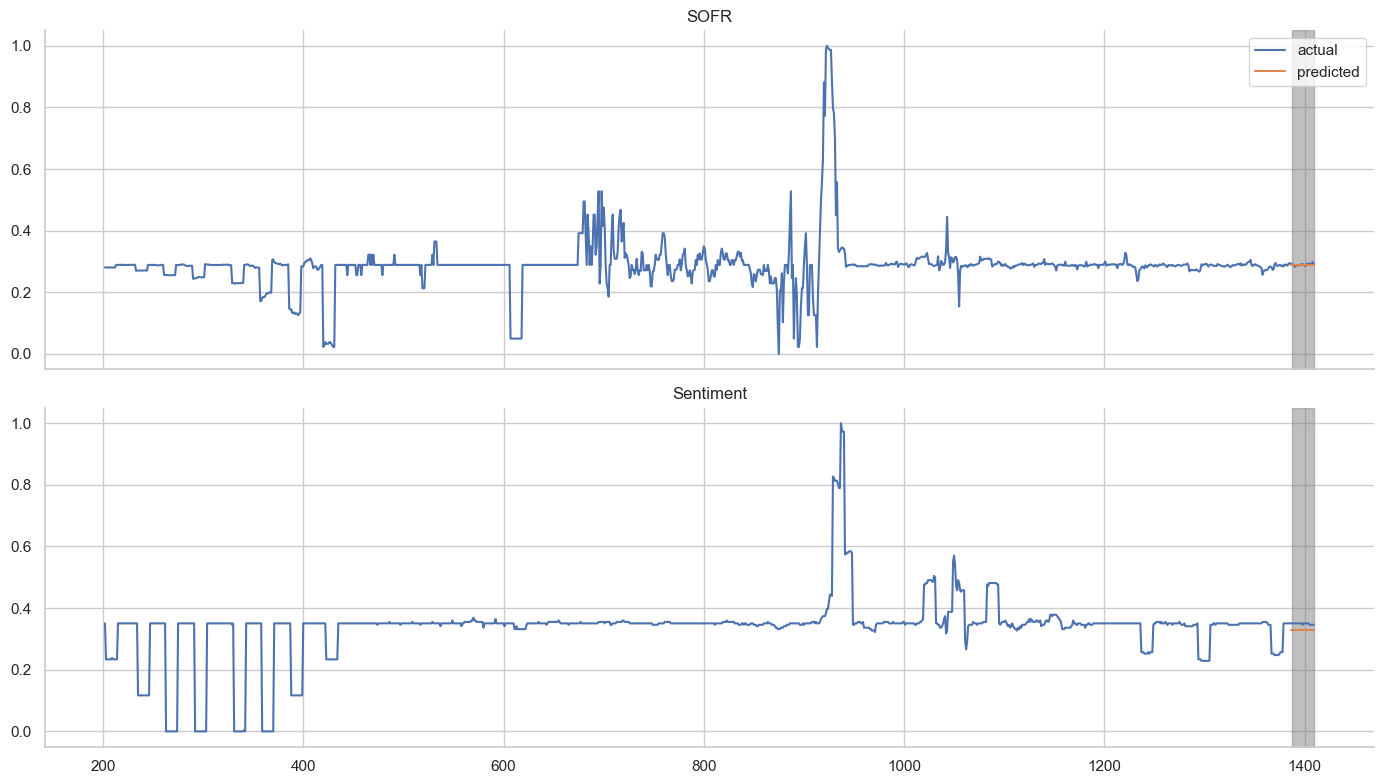

In [36]:
preds.index = df_transformed.index[start:]

fig, axes = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)

df_transformed.sofr_rate.loc["2010":].plot(ax=axes[0], label="actual", title="SOFR")
preds.sofr_rate.plot(label="predicted", ax=axes[0])
trans = mtransforms.blended_transform_factory(axes[0].transData, axes[0].transAxes)
axes[0].legend()
axes[0].fill_between(
    x=df_transformed.index[start + 1 :],
    y1=0,
    y2=1,
    transform=trans,
    color="grey",
    alpha=0.5,
)

trans = mtransforms.blended_transform_factory(axes[0].transData, axes[1].transAxes)
df_transformed.effr_rate.loc["2010":].plot(
    ax=axes[1], label="actual", title="Sentiment"
)
preds.effr_rate.plot(label="EFFR", ax=axes[1])
axes[1].fill_between(
    x=df_transformed.index[start + 1 :],
    y1=0,
    y2=1,
    transform=trans,
    color="grey",
    alpha=0.5,
)
axes[1].set_xlabel("")
sns.despine()
fig.tight_layout()

### Out-of-sample forecasts

A visualization of actual and predicted values shows how the prediction lags the actual values and does not capture non-linear out-of-sample patterns well:

In [37]:
forecast = model.forecast(steps=24)

TypeError: cannot do slice indexing on Int64Index with these indexers [2010] of type str

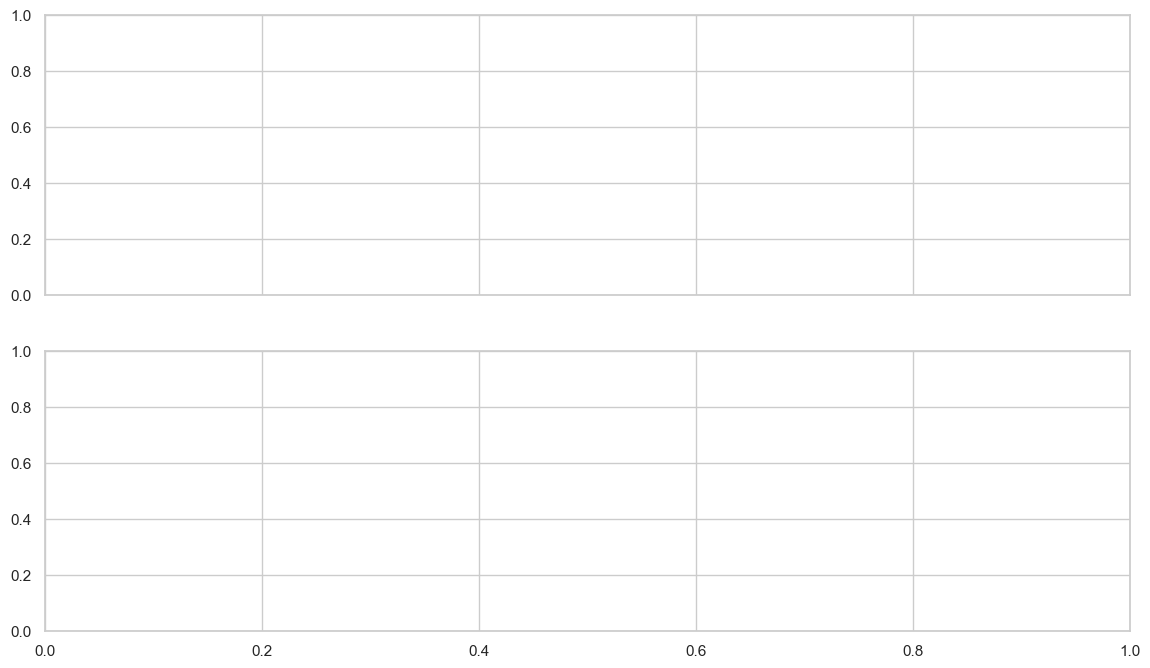

In [38]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)

df_transformed["2010":].sofr_rate.plot(ax=axes[0], label="actual", title="Liquor")
preds.sofr_rate.plot(label="predicted", ax=axes[0])
axes[0].legend()

df_transformed["2010":].effr_rate.plot(ax=axes[1], label="actual", title="Sentiment")
preds.effr_rate.plot(label="predicted", ax=axes[1])
axes[1].legend()
axes[1].set_xlabel("")
sns.despine()
fig.tight_layout()

In [ ]:
mean_absolute_error(forecast, df_transformed.iloc[492:])